# Insert Packages
- [numpy](https://www.numpy.org/) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a library to plot graphs in Python.
- [h5py](http://www.h5py.org) is a common package to interact with a dataset that is stored on an H5 file.

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

# Dataset
**Problem Statement**: You are given a dataset containing:
    - a training set of m_train images labelled as cat (1) or non-cat (0)
    - a test set of m_test images labelled as cat and non-cat
    - each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB).

In [2]:
train_dataset = h5py.File('train_catvnoncat.h5', "r")
train_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

test_dataset = h5py.File('test_catvnoncat.h5', "r")
test_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
train_y = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
test_y = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

The following code will show you an image in the dataset. Feel free to change the index and re-run the cell multiple times to see other images.

y = 0. It's a non-cat picture.


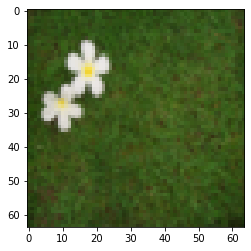

In [3]:
index = 6
plt.imshow(train_x_orig[index])
print("y = " + str(train_y[0, index]) + ". It's a " + classes[train_y[0, index]].decode("utf-8") + " picture.")

# Explore the dataset

In [4]:
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print("Number of training examples: " + str(m_train))
print("Number of testing examples: " + str(m_test))
print("Each image is size of: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print("train_x_orig shape: " + str(train_x_orig.shape))
print("train_y shape: " + str(train_y.shape))
print("test_x_orig shape: " + str(test_x_orig.shape))
print('test_y shape: " str(test_y.shape))"')

Number of training examples: 209
Number of testing examples: 50
Each image is size of: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: " str(test_y.shape))"


In [5]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print("train_x's shape: " + str(train_x.shape))
print("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


## L Layer Deep Neural Network
<img src="architect.png" style="width:650px;height:400px;">
<caption><center> <u>Figure 3</u>: L-layer neural network. <br> The model can be summarized as: ***[LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID***</center></caption>

<u>Detailed Architecture of figure 3</u>:
- The input is a (64,64,3) image which is flattened to a vector of size (12288,1).
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ and then you add the intercept $b^{[1]}$. The result is called the linear unit.
- Next, you take the relu of the linear unit. This process could be repeated several times for each $(W^{[l]}, b^{[l]})$ depending on the model architecture.
- Finally, you take the sigmoid of the final linear unit. If it is greater than 0.5, you classify it to be a cat.

### General methodology

    1. Initialize parameters / Define hyperparameters
    2. Loop for num_iterations:
        a. Forward propagation
        b. Compute cost function
        c. Backward propagation
        d. Update parameters (using parameters, and grads from backprop) 
    4. Use trained parameters to predict labels

In [6]:
def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    parameters = {}
    L = len(layer_dims)          

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) #*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

In [7]:
def linear_forward(A, W, b):
    # Implement the linear part of a layer's forward propagation.
    Z = W.dot(A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

In [8]:
def sigmoid(Z):
    # Implements the sigmoid activation in numpy
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

def relu(Z):
    # Implement the RELU function.
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache


In [9]:
def linear_activation_forward(A_prev, W, b, activation):
    # Implement the forward propagation for the LINEAR->ACTIVATION layer
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache


In [10]:
def L_model_forward(X, parameters):
    # Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    caches = []
    A = X
    L = len(parameters) // 2                 
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)
    
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "sigmoid")
    caches.append(cache)
    
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches

In [11]:
def compute_cost(AL, Y):
    # Implement the cost function
    m = Y.shape[1]

    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    
    cost = np.squeeze(cost)     
    assert(cost.shape == ())
    
    return cost


In [12]:
def linear_backward(dZ, cache):
    # Implement the linear portion of backward propagation for a single layer (layer l)
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1./m * np.dot(dZ,A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [13]:
def relu_backward(dA, cache):
    # Implement the backward propagation for a single RELU unit.
    Z = cache
    dZ = np.array(dA, copy=True)
    
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def sigmoid_backward(dA, cache):
    # Implement the backward propagation for a single SIGMOID unit.
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

In [14]:
def linear_activation_backward(dA, cache, activation):
    # Implement the backward propagation for the LINEAR->ACTIVATION layer.
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

In [15]:
def L_model_backward(AL, Y, caches):
    # Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads


In [16]:
def update_parameters(parameters, grads, learning_rate):
    # Update parameters using gradient descent
    L = len(parameters) // 2 

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters

In [17]:
layers_dims = [12288, 20, 70, 5, 1] 

In [18]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost = False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    costs = []                       
    
    parameters = initialize_parameters_deep(layers_dims)
    
    for i in range(0, num_iterations):

        AL, caches = L_model_forward(X, parameters)
        
        cost = compute_cost(AL, Y)
        grads = L_model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Run the cell below to train your model. 

Cost after iteration 0: 0.691865
Cost after iteration 100: 0.547016
Cost after iteration 200: 0.439298
Cost after iteration 300: 0.449095
Cost after iteration 400: 0.294540
Cost after iteration 500: 0.195201
Cost after iteration 600: 0.054688
Cost after iteration 700: 0.021327
Cost after iteration 800: 0.012376
Cost after iteration 900: 0.008321
Cost after iteration 1000: 0.006119
Cost after iteration 1100: 0.004741
Cost after iteration 1200: 0.003823
Cost after iteration 1300: 0.003167
Cost after iteration 1400: 0.002682
Cost after iteration 1500: 0.002313
Cost after iteration 1600: 0.002025
Cost after iteration 1700: 0.001794
Cost after iteration 1800: 0.001604
Cost after iteration 1900: 0.001448
Cost after iteration 2000: 0.001316
Cost after iteration 2100: 0.001205
Cost after iteration 2200: 0.001108
Cost after iteration 2300: 0.001025
Cost after iteration 2400: 0.000952


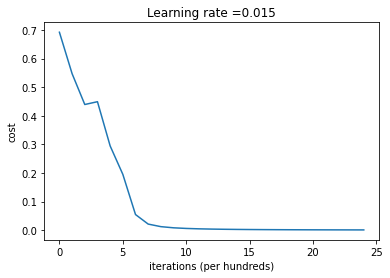

In [19]:
parameters = L_layer_model(train_x, train_y, layers_dims, learning_rate = 0.015, num_iterations = 2500, print_cost = True)

In [20]:
def predict(X, y, parameters):
    m = X.shape[1]
    n = len(parameters) // 2 
    p = np.zeros((1,m))
    
    probas, caches = L_model_forward(X, parameters)

    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

In [21]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9999999999999998


In [22]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.78


The 4-layer neural network has performance of 78%. 

This is good performance for this task.